**Business Goal**

You are required to model the price of cars with the available independent variables. It will be used by the management to understand how exactly the prices vary with the independent variables. They can accordingly manipulate the design of the cars, the business strategy etc. to meet certain price levels. Further, the model will be a good way for management to understand the pricing dynamics of a new market

## Import libariers and data 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

from sklearn.metrics import mean_absolute_error , r2_score 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge

import warnings
warnings.filterwarnings('ignore')

palette = sns.color_palette("Spectral")

In [2]:
df = pd.read_csv("car price data.csv")
df.head()

,CarName,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero giulia,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero stelvio,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero Quadrifoglio,hatchback,rwd,front,gas,std,two,six,ohcv,mpfi,...,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi 100 ls,sedan,fwd,front,gas,std,four,four,ohc,mpfi,...,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi 100ls,sedan,4wd,front,gas,std,four,five,ohc,mpfi,...,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


In [3]:
df.shape

(210, 25)

## Deal with null values and duplicated rows

In [4]:
def deal_with_nulls_and_duplicates( df , drop_na = False ):
    
    # handle with missing data 
    if drop_na is True:
        df.dropna(inplace=True)
    
    else:
        for col in df.columns:
        
            # drop columns that are more than half nan-values.
            if df[col].isna().sum()/len(df) > 0.5 :
                df.drop(columns=col , inplace = True)
        
            # fill nulls .
            elif df[col].dtype =="float":
                df[col] = df[col].fillna(df[col].mean())
            
            elif df[col].dtype =="int":
                df[col] = df[col].fillna(df[col].median())
            
            elif df[col].dtype =="object":
                df[col] = df[col].fillna(df[col].mode()[0])
            
    # remove duplicated rows.
    df.drop_duplicates(inplace=True)
    
    return df.head()

In [5]:
deal_with_nulls_and_duplicates(df)

,CarName,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,...,curbweight,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,alfa-romero giulia,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,13495.0
1,alfa-romero stelvio,convertible,rwd,front,gas,std,two,four,dohc,mpfi,...,2548,130,3.47,2.68,9.0,111,5000,21,27,16500.0
2,alfa-romero Quadrifoglio,hatchback,rwd,front,gas,std,two,six,ohcv,mpfi,...,2823,152,2.68,3.47,9.0,154,5000,19,26,16500.0
3,audi 100 ls,sedan,fwd,front,gas,std,four,four,ohc,mpfi,...,2337,109,3.19,3.40,10.0,102,5500,24,30,13950.0
4,audi 100ls,sedan,4wd,front,gas,std,four,five,ohc,mpfi,...,2824,136,3.19,3.40,8.0,115,5500,18,22,17450.0


## Univariate analysis

we will use boxplot and histgram to detect outliers and skewness of the data . 

In [12]:
# Making a list of all numerical variables
num_columns = df.select_dtypes(exclude = 'object').columns

print("Number of numerical features are: ", len(num_columns))

Number of numerical features are:  15


In [7]:
def two_plots_num_column(feature):
    
    print(f"the skewness value of {feature} column = {df[feature].skew():.2f}")
    plt.figure(figsize=(10,4))
    
    plt.subplot(1,2,1)
    plt.title('histgram')
    sns.histplot(data=df, x=feature, kde=True)
    plt.axvline(x = df[feature].mean(), c = 'red')
    plt.axvline(x = df[feature].median(), c = 'green')

    plt.subplot(1,2,2)
    plt.title('Boxplot')
    sns.boxplot(y=df[feature])

the skewness value of horsepower column = 1.41


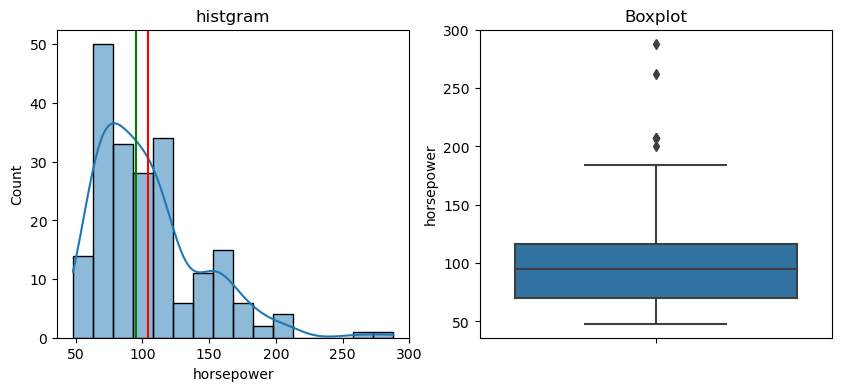

In [11]:
two_plots_num_column("horsepower")

**There are some outliers in horsepower column and Right-skewed.**

the skewness value of stroke column = -0.69


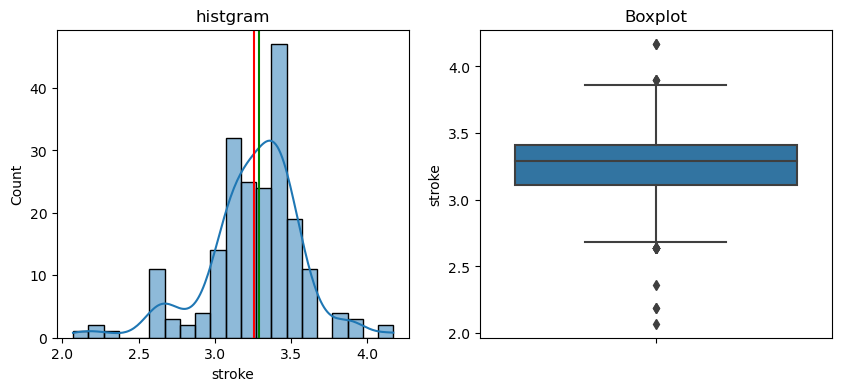

In [9]:
two_plots_num_column("stroke")

the skewness value of carlength column = 0.16


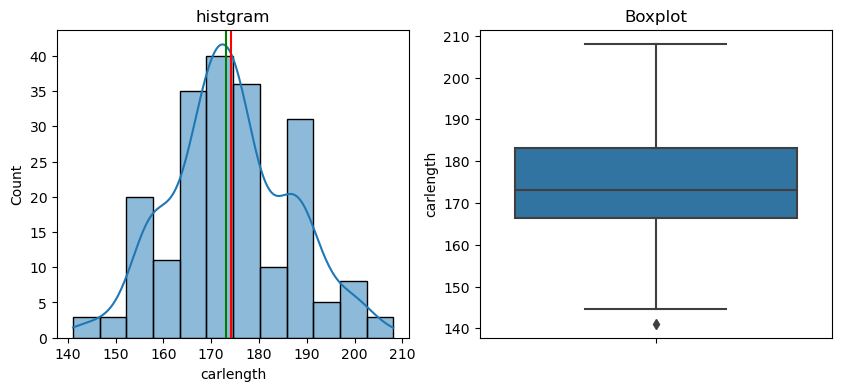

In [10]:
two_plots_num_column("carlength" )

**carlength column is nearly normal distributed**

the skewness value of price column = 1.78


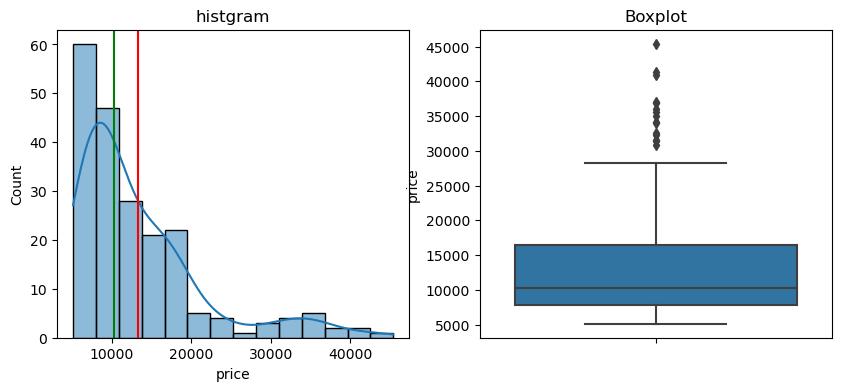

In [15]:
two_plots_num_column("price" )

**price column is a Right-skewed distributed.**

##  Handling outliers and skewness

#### 1- handle with outliers
we will replace outliers data with median or mean based on feature's data ,

we cannot drop outliers becouse of data's size 

In [14]:
def deal_with_outliers(df , columns = None):
    
    if columns is None:
        columns = df.select_dtypes(include=['number']).drop(columns= "quality").columns

    for col in columns:
        q1, q3 = df[col].quantile([0.25, 0.75])
        iqr = q3 - q1
        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        
        # replace the outliers with the lower/upper bound with the median or mean of the column
        if df[col].dtype =="int":
            
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan
            df[col].fillna(df[col].median(), inplace=True)
            
        elif df[col].dtype =="float":
            
            df.loc[(df[col] < lower_bound) | (df[col] > upper_bound), col] = np.nan
            df[col].fillna(df[col].mean(), inplace=True)
            
    return df

In [15]:
df = deal_with_outliers(df , columns=['compressionratio','stroke', 'horsepower'])

the skewness value of compressionratio column = -0.86


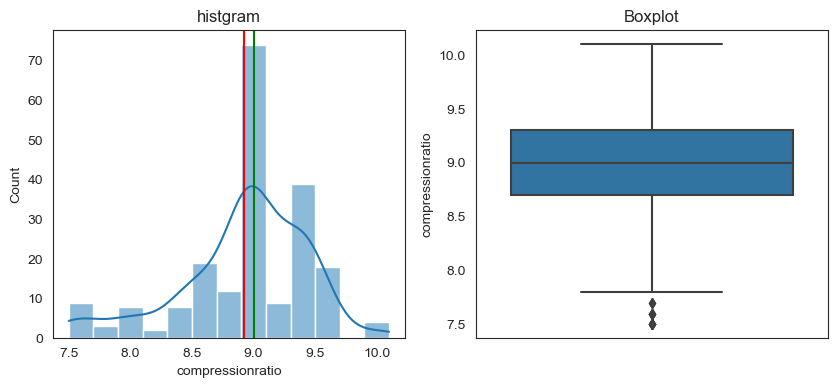

In [16]:
# check 
two_plots_num_column('compressionratio')

the skewness value of horsepower column = 1.41


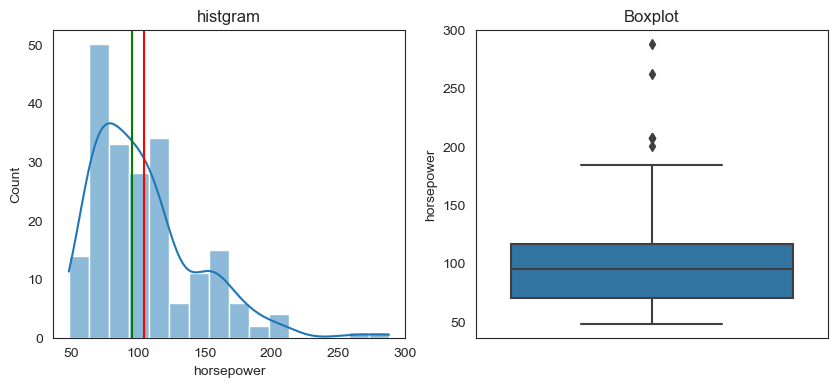

In [17]:
# check
two_plots_num_column('horsepower')

#### 2- handle with skewness
 we will use log transform that used to reduce the impect of outliers and skewness

In [18]:
# handle with skewness

for col in ['horsepower','wheelbase' ,'enginesize']:
    df[col]=np.log(df[col])

the skewness value of enginesize column = 0.86


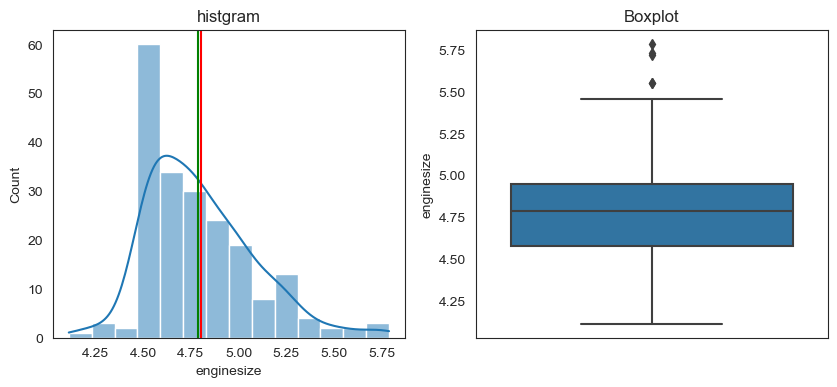

In [19]:
two_plots_num_column('enginesize')

the skewness value of wheelbase column = 0.88


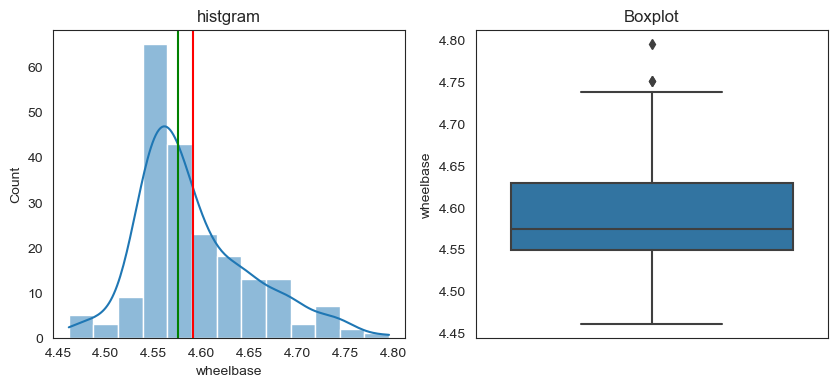

In [20]:
# check
two_plots_num_column('wheelbase')

## Explore catigorical data

In [13]:
# Making a list of all categorical variables
cat_columns = df.select_dtypes(include = 'object').columns

print("Number of categorical features are: ", len(cat_columns))

Number of categorical features are:  10


In [14]:
print(f"number of unique values = {df['CarName'].nunique()} \n")

number of unique values = 147 



There are alot of unique values in **CarName** column . we will split just the campany name and rename the column to **company name**.

In [23]:
# create company name column

df["company name"] = df["CarName"].str.split(" ", expand=True)[0]

In [24]:
# drop CarName column

df.drop(columns="CarName", inplace=True)
df.head()

,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,symboling,...,enginesize,boreratio,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price,company name
0,convertible,rwd,front,gas,std,two,four,dohc,mpfi,3,...,4.867534,3.47,2.68,9.0,4.709530,5000,21,27,13495.0,alfa-romero
1,convertible,rwd,front,gas,std,two,four,dohc,mpfi,3,...,4.867534,3.47,2.68,9.0,4.709530,5000,21,27,16500.0,alfa-romero
2,hatchback,rwd,front,gas,std,two,six,ohcv,mpfi,1,...,5.023881,2.68,3.47,9.0,5.036953,5000,19,26,16500.0,alfa-romero
3,sedan,fwd,front,gas,std,four,four,ohc,mpfi,2,...,4.691348,3.19,3.40,10.0,4.624973,5500,24,30,13950.0,audi
4,sedan,4wd,front,gas,std,four,five,ohc,mpfi,2,...,4.912655,3.19,3.40,8.0,4.744932,5500,18,22,17450.0,audi


In [25]:
print(f"number of unique values = {df['company name'].nunique()} \n")

print(df['company name'].unique())

number of unique values = 28 

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'maxda' 'mazda' 'buick' 'mercury' 'mitsubishi' 'Nissan' 'nissan'
 'peugeot' 'plymouth' 'porsche' 'porcshce' 'renault' 'saab' 'subaru'
 'toyota' 'toyouta' 'vokswagen' 'volkswagen' 'vw' 'volvo']


**Note that**

* maxda = mazda
* Nissan = nissan
* porsche = porcshce
* toyota = toyouta
* vokswagen = volkswagen = vw

In [26]:
df.replace({'company name':{"maxda":"mazda" , 
                        "Nissan":"nissan" ,
                        "porcshce":"porsche" ,
                        "toyouta":"toyota" ,
                        "vokswagen":"volkswagen" ,
                        "vw":"volkswagen"}},inplace=True)

In [27]:
print(f"number of unique values = {df['company name'].nunique()} \n")

print(df['company name'].unique())

number of unique values = 22 

['alfa-romero' 'audi' 'bmw' 'chevrolet' 'dodge' 'honda' 'isuzu' 'jaguar'
 'mazda' 'buick' 'mercury' 'mitsubishi' 'nissan' 'peugeot' 'plymouth'
 'porsche' 'renault' 'saab' 'subaru' 'toyota' 'volkswagen' 'volvo']


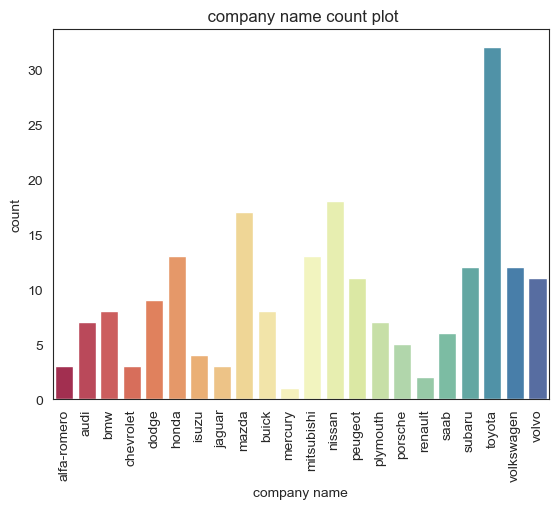

In [30]:
# plot company name column.

sns.countplot(x="company name", data=df ,palette="Spectral")
plt.xticks(rotation=90)
plt.title(" company name count plot") ; # add a title to the subplot


**toyota is a the top company prefered**

In [31]:
#Create a pivot table of categorical data. the values come from the "price" column, aggregated by the mean.
def plot_vs_average_price(feature):

    # make table of unique values of feature vs average price
    Feature_table=pd.pivot_table(
        df,
        index=feature,
        values="price",
        aggfunc=np.mean
    ).sort_values(by="price")
    
    # create barplot
    fig= sns.barplot(y="price",x=Feature_table.index, data = Feature_table, palette='pastel')
    plt.xticks(rotation=90)
    plt.title(f'{feature} type vs Average Price')
    
    return fig

In [32]:
def two_plots_cat_column(feature):
    
    plt.figure(figsize=(12,6))
    
    plt.subplot(1,2,1)
    plt.title(f'{feature} Histogram')
    sns.countplot(data=df , x=feature ,palette="Set2")
    plt.xticks(rotation=90)

    plt.subplot(1,2,2)
    plt.title(f'{feature} vs Price')
    sns.boxplot(x=df[feature], y=df["price"],palette="Set2")
    plt.xticks(rotation=90)
    
    plt.tight_layout()


#### 1- enginetype column

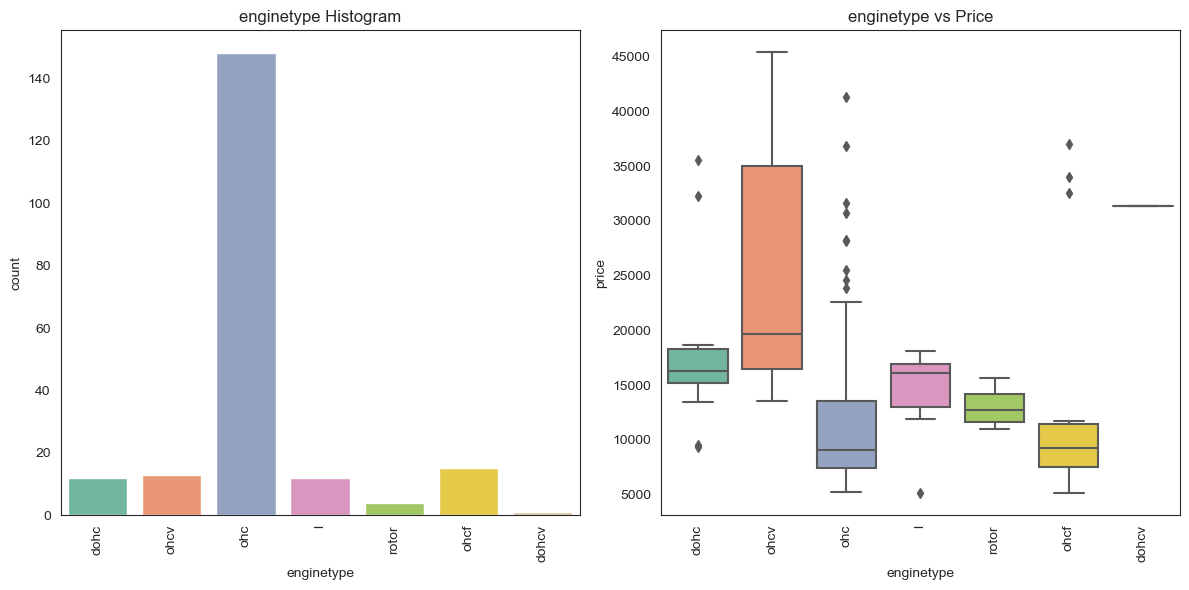

In [33]:
two_plots_cat_column("enginetype")


<AxesSubplot:title={'center':'enginetype type vs Average Price'}, xlabel='enginetype', ylabel='price'>

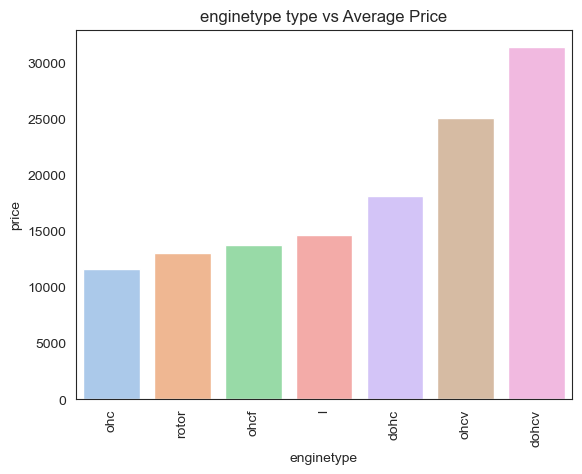

In [34]:
plot_vs_average_price("enginetype")

In [35]:
df["enginetype"].value_counts()

ohc      148
ohcf      15
ohcv      13
dohc      12
l         12
rotor      4
dohcv      1
Name: enginetype, dtype: int64

***Observation***

* `ohc` Engine type seems to be most favored type.
* `ohc` and `ohcf` have the low price range.
* `ohcv` has the highest price range .
* `dohcv` has only one row.
* `dohcv` is the the most expensive type motor and the `ohc` is the cheapest . that is show why the `ohc` type is most favored type

#### 2- fueltype column

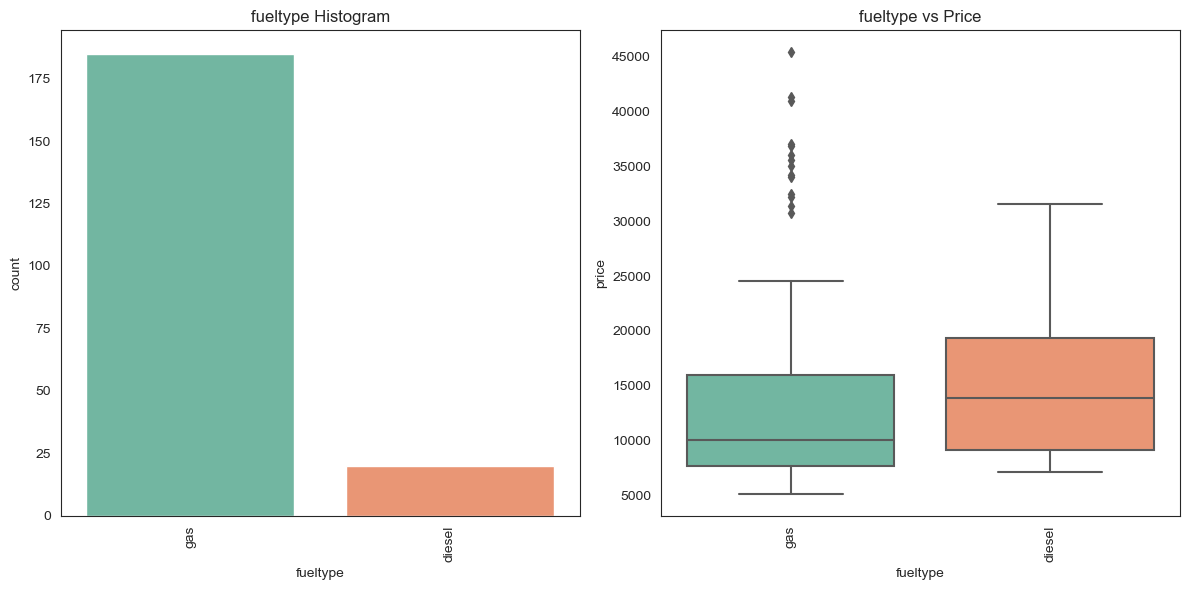

In [36]:
two_plots_cat_column("fueltype")

<AxesSubplot:title={'center':'fueltype type vs Average Price'}, xlabel='fueltype', ylabel='price'>

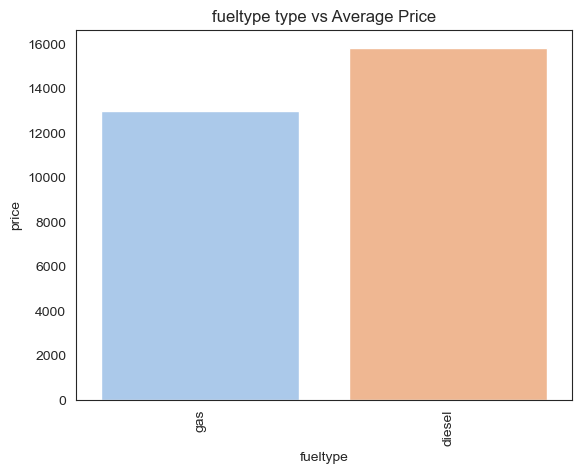

In [37]:
plot_vs_average_price("fueltype")

In [38]:
df["fueltype"].value_counts()

gas       185
diesel     20
Name: fueltype, dtype: int64

***Observation***

* `gas` type seems to be most favored type.
* `gas` type has the lower price range than `diesel` type.
* `diesel` has higher average price than `gas`.


#### 3- carbody

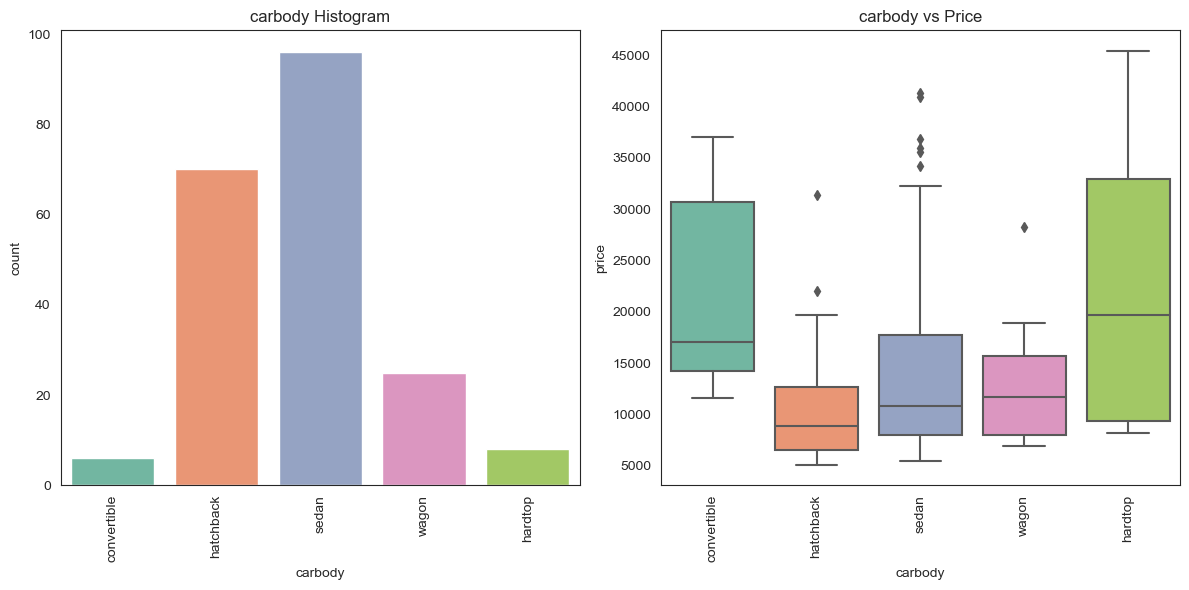

In [39]:
two_plots_cat_column("carbody")

<AxesSubplot:title={'center':'carbody type vs Average Price'}, xlabel='carbody', ylabel='price'>

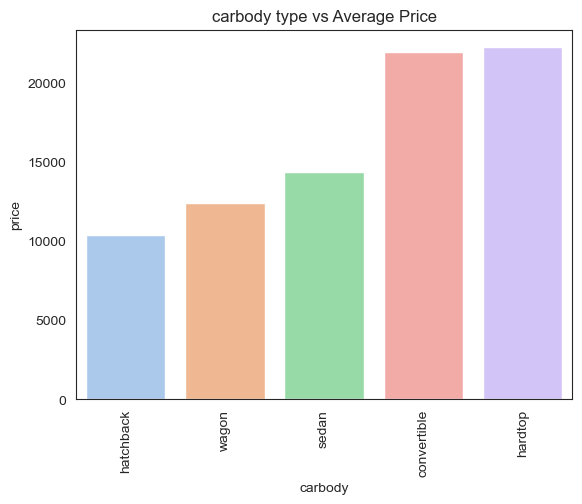

In [40]:
plot_vs_average_price("carbody")

In [41]:
df["carbody"].value_counts()

sedan          96
hatchback      70
wagon          25
hardtop         8
convertible     6
Name: carbody, dtype: int64

***Observations***

* `hardtop` body `convertible` body have the same mean of price and the higher price.
* `convertible` body is the most unfavored body.
* `sedan` body is most favored one.

#### 4- company name column

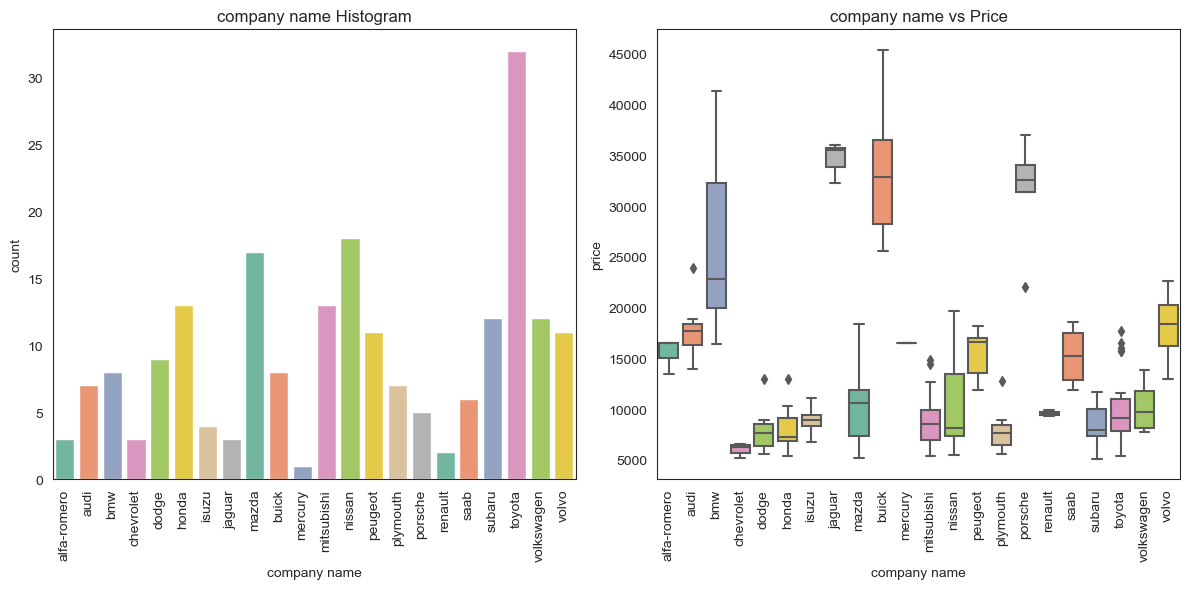

In [42]:
two_plots_cat_column("company name")

<AxesSubplot:title={'center':'company name type vs Average Price'}, xlabel='company name', ylabel='price'>

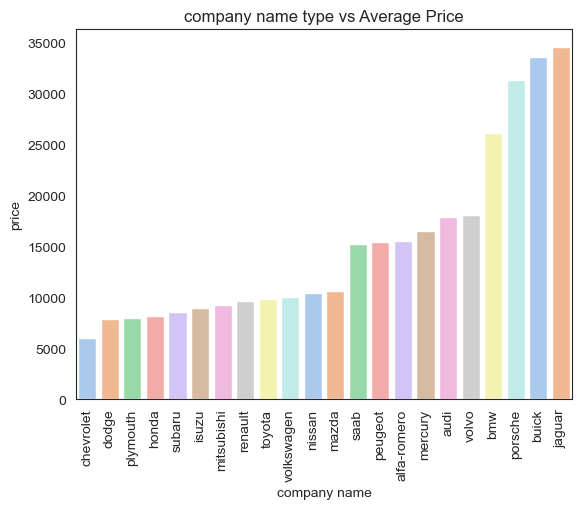

In [43]:
plot_vs_average_price("company name")

**Observations**

* `Jaguar` and `Buick` company have highest average price.
* `toyota` is a favored company

#### 5- enginelocation column

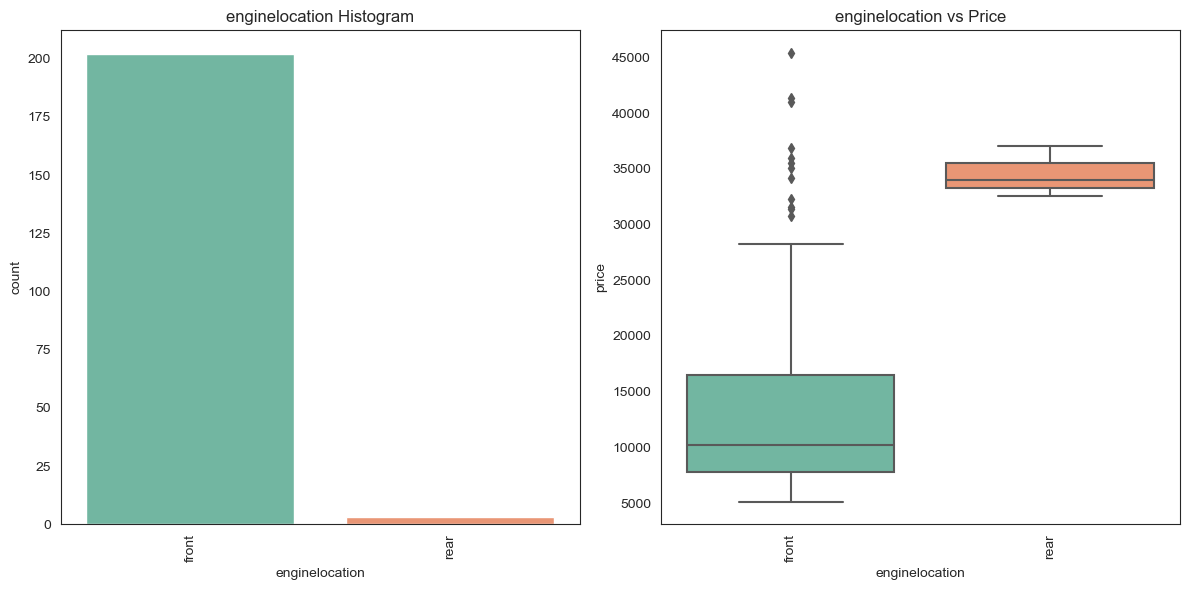

In [44]:
two_plots_cat_column('enginelocation')

<AxesSubplot:title={'center':'enginelocation type vs Average Price'}, xlabel='enginelocation', ylabel='price'>

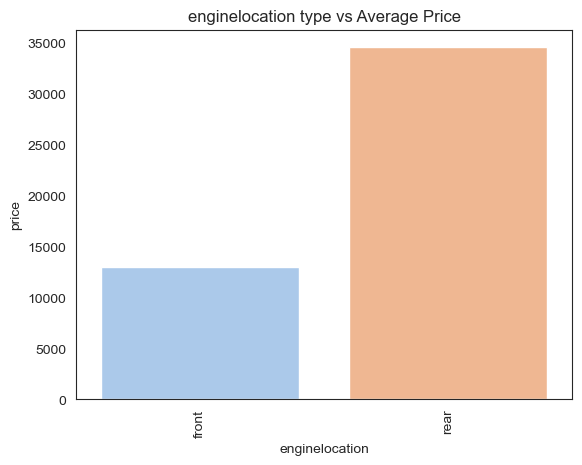

In [45]:
plot_vs_average_price('enginelocation')

In [46]:
df['enginelocation'].value_counts()

front    202
rear       3
Name: enginelocation, dtype: int64

***Observations***

* almost all cars have front enginelocation . just three cars have rear location.
* cars that have rear enginelocation are more expensive than anther. 

#### 6- cylindernumber column

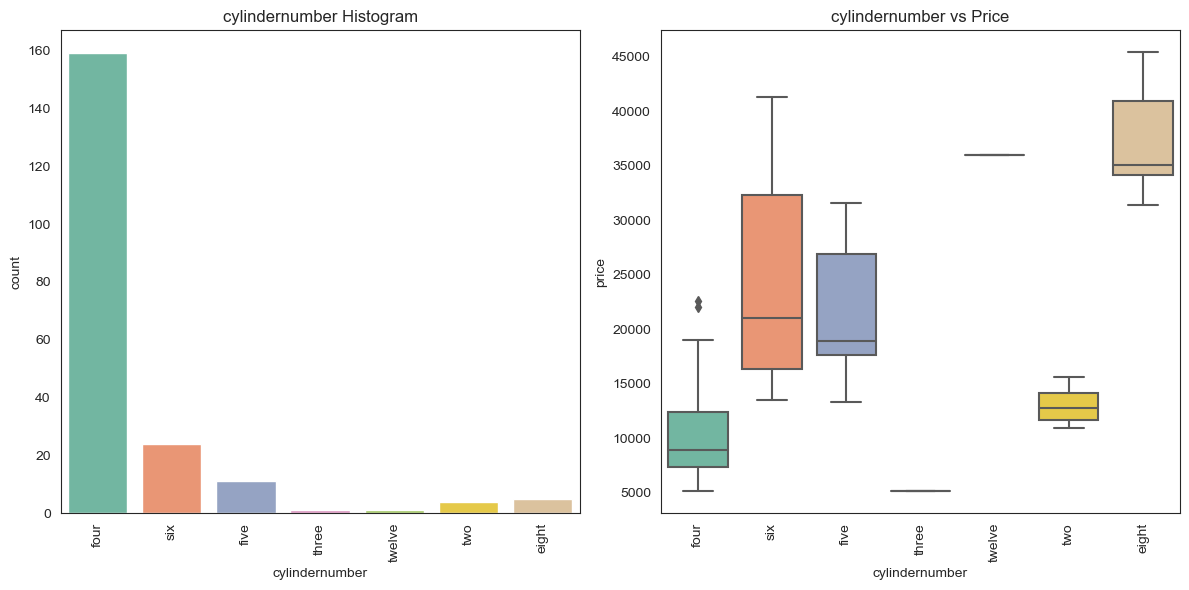

In [47]:
two_plots_cat_column('cylindernumber')

<AxesSubplot:title={'center':'cylindernumber type vs Average Price'}, xlabel='cylindernumber', ylabel='price'>

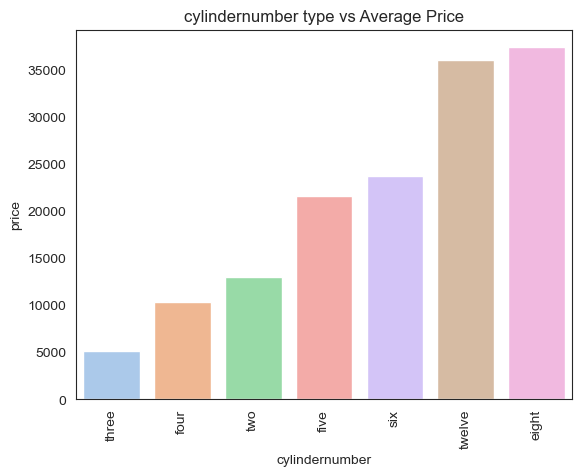

In [48]:
plot_vs_average_price('cylindernumber')

***Observations***

* Most common number of cylinders is `four`.
* `eight`and `twelve` cylinders have the highest price range.

## Explore target column

the skewness value of price column = 1.78


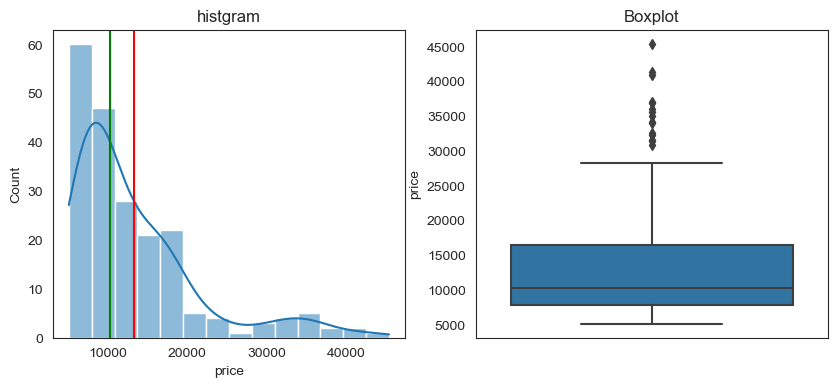

In [49]:
two_plots_num_column('price')

In [50]:
print(df["price"].describe(percentiles = [0.25,0.50,0.75,0.85,0.90,1]))

count      205.000000
mean     13276.710571
std       7988.852332
min       5118.000000
25%       7788.000000
50%      10295.000000
75%      16503.000000
85%      18500.000000
90%      22563.000000
100%     45400.000000
max      45400.000000
Name: price, dtype: float64


***Observations***

* The plot seemed to be right-skewed, meaning that the most prices in the dataset are low(Below 15,000).
* There is a significant difference between the mean and the median of the price distribution.
* The data points are far spread out from the mean, which indicates a high variance in the car prices.(85% of the prices are below 18,500, whereas the remaining 15% are between 18,500 and 45,400.)

let's transform price column to reduce the impect of skewness

In [51]:
# transform target column

df['price']=np.log(df['price'])

## Bivariate analysis
we will use heatmap and pairplot to know the rlationships between features 
and check if there is multicollinearity or not

<AxesSubplot:>

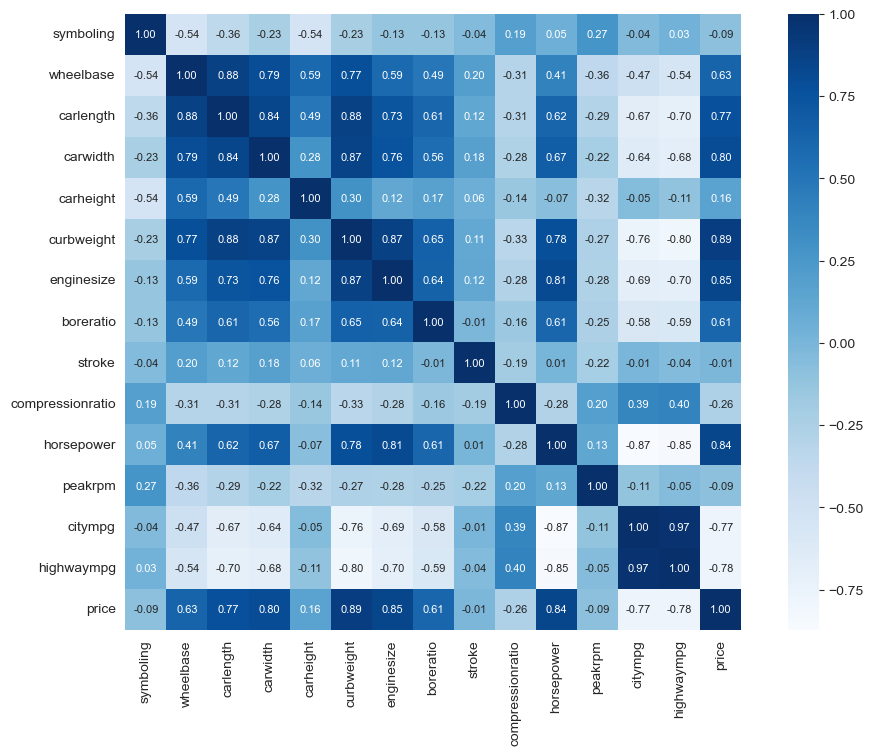

In [52]:
plt.figure(figsize=(12,8))
corr = df.corr()
sns.heatmap(corr, cbar=True, square=True, fmt = '.2f', annot = True, annot_kws={'size':8}, cmap = 'Blues')

***Observations***

* `enginesize`, `boreratio`, `horsepower` and `curbweight` have a significant positive correlation with price.
* `citympg`, `highwaympg` have a significant negative correlation with price.
* `wheelbase` and `boreratio` have a medirate correlation with price
* `carheight`,`peakrpm`,`stroke`,`symboling` and `compressionratio` have low correlation with price.
* `highwaympg` and `citympg` have high correlation with each other.
* `carbweight`,`carlength` and `carwidth` have high correlation with each other.

In [53]:
# with low correlation with target

df.drop(columns=["compressionratio","peakrpm","carheight","stroke","symboling"],inplace=True)

In [54]:
# drop columns with multicollinearity

df.drop(columns=["wheelbase", "enginesize","citympg","carlength","carwidth"],inplace=True)

<Figure size 600x600 with 0 Axes>

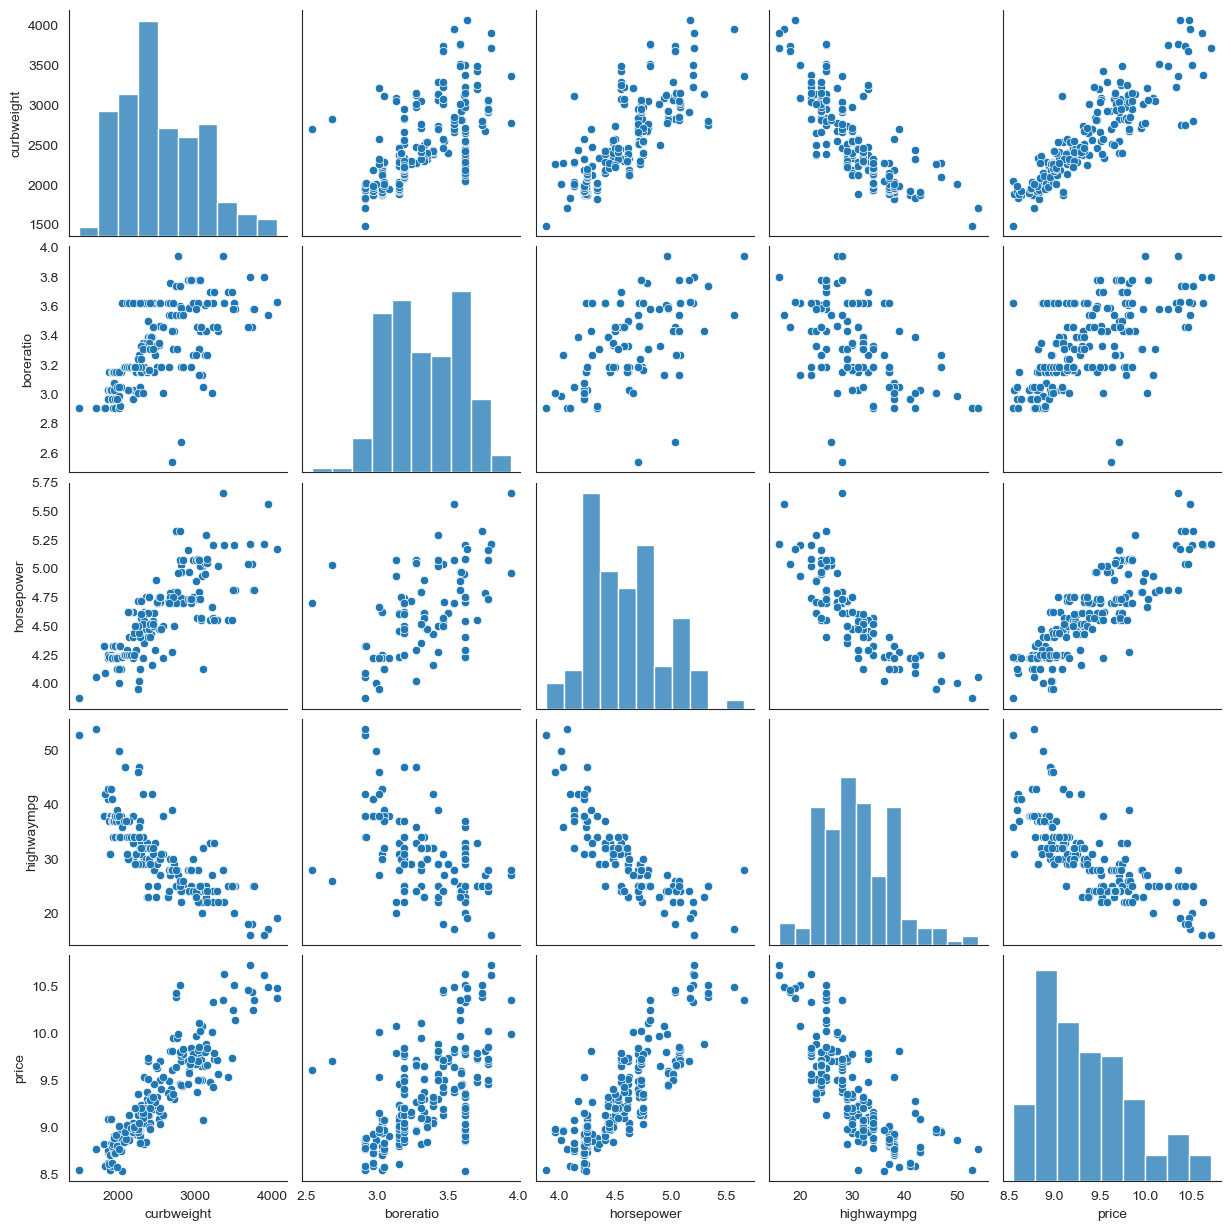

In [55]:
num_columns = df.select_dtypes("number").columns
plt.figure(figsize=(6,6))
sns.pairplot(df[num_columns])
plt.show();

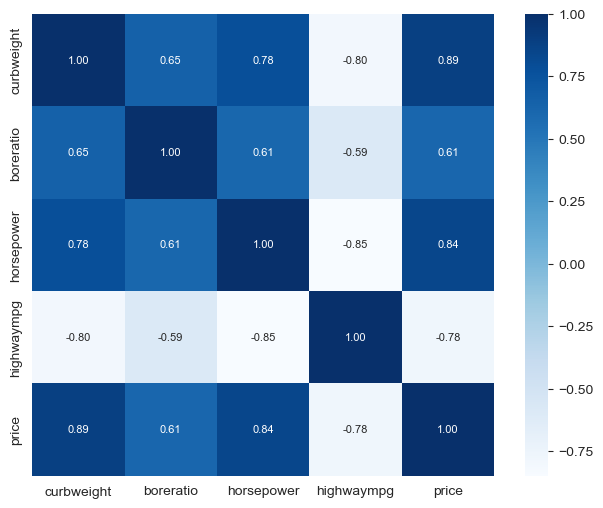

In [56]:
plt.figure(figsize=(8,6))
corr = df.corr()
sns.heatmap(corr, cbar=True, square=True, fmt = '.2f', annot = True, annot_kws={'size':8}, cmap = 'Blues');

As you see the relationship between price and other feature is linear so we overcome the problem of non-linearity of data .
and we try to reduce multicollinearity by droping some features. so now we can build the model

## Build a model


In [58]:
df.head()

,carbody,drivewheel,enginelocation,fueltype,aspiration,doornumber,cylindernumber,enginetype,fuelsystem,curbweight,boreratio,horsepower,highwaympg,price,company name
0,convertible,rwd,front,gas,std,two,four,dohc,mpfi,2548,3.47,4.709530,27,9.510075,alfa-romero
1,convertible,rwd,front,gas,std,two,four,dohc,mpfi,2548,3.47,4.709530,27,9.711116,alfa-romero
2,hatchback,rwd,front,gas,std,two,six,ohcv,mpfi,2823,2.68,5.036953,26,9.711116,alfa-romero
3,sedan,fwd,front,gas,std,four,four,ohc,mpfi,2337,3.19,4.624973,30,9.543235,audi
4,sedan,4wd,front,gas,std,four,five,ohc,mpfi,2824,3.19,4.744932,22,9.767095,audi


### 1- Baseline

The first step in building a model is baselining. To do this, ask yourself how you will know if the model you build is performing well?" One way to think about this is to see how a "dumb" model would perform on the same data. Some people also call this a naïve or baseline model, but it's always a model makes only one prediction

In [59]:
# spilte our data verticlly to y and X

y = df["price"]
X =df.drop(columns="price")

In [60]:
#Create a list named y_pred_baseline that contains the value of y_mean has the same length at y.
y_mean = y.mean()
y_pred_baseline= [y_mean]*len(y)
print("Mean apt price:", round(y_mean))

#main absolute error between y and baisline(mean of y)
mae = mean_absolute_error(y_pred_baseline , y )
print("Baseline MAE:", mae)

Mean apt price: 9
Baseline MAE: 0.4165925930958537


It tells us that our model needs to have mean absolute error below 0.416 in order to be useful.

### 2- Iterate

The next step in building a model is iterating. This involves building a model, training it, evaluating it, and then repeating the process until you're happy with the model's performance.

* what is pipeline ?

Many machine learning applications will require you to run the same steps many times, usually with new or updated data. scikit-learn allows you to define a set of steps to process data for machine learning in a reproducible manner using a pipeline.

In [61]:
# Create a pipeline named model that contains a OneHotEncoder and Ridge predictor.
model = make_pipeline(
    OneHotEncoder(),
    Ridge()
)
model.fit(X, y)

Pipeline(steps=[('onehotencoder', OneHotEncoder()), ('ridge', Ridge())])

### 3- Evaluate


#### 1- mean absolute error of y_pred

Calculate the training mean absolute error for your predictions as compared to the true targets in y.

In [62]:
# create y_pred
y_pred = model.predict(X)

print("Mean Absolute Error:", mean_absolute_error(y_pred , y))
print(" R2-score : ",r2_score(y, y_pred))

Mean Absolute Error: 0.04358539535663858
 R2-score :  0.9878564849364411


#### 2- check about assumptions of linear regression

There are assumption that we need to keep it in our mind to better regression line fit for our model:

1- mean of residuals

2- normality of residuals

3- hemoscedasticity / heteroscedasticity

In [63]:
# create a list of residuals 
res = y.values - y_pred

print(f" the mean of residuals is : {np.mean(res)}")

 the mean of residuals is : -3.2061074662345983e-16


you can see the mean of residuals is almost equal to zero . that's very good

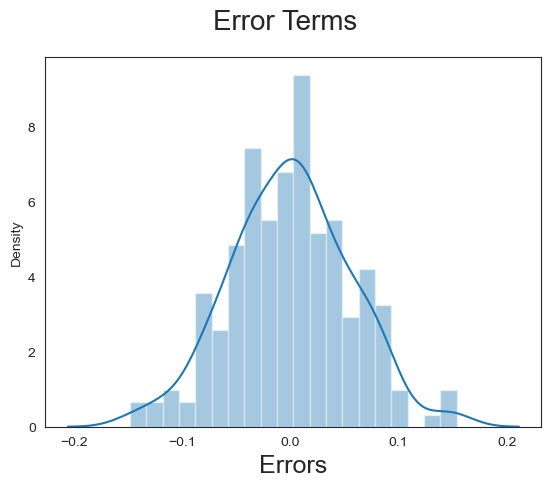

In [64]:
# Plot the histogram of the error terms

fig = plt.figure()
sns.distplot(res , bins=20)
fig.suptitle('Error Terms', fontsize = 20)                  # Plot heading 
plt.xlabel('Errors', fontsize = 18)   ;

Error terms is approximately normally distributed, so the assumption on the linear modeling seems to be fulfilled.

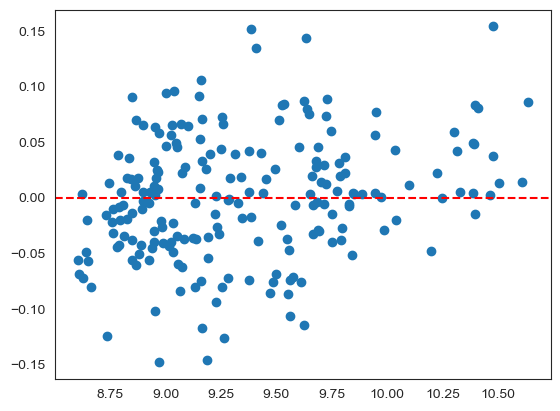

In [65]:
plt.scatter(y_pred , res)
plt.axhline(y=0,color="red" ,linestyle="--")
plt.show()

 Hope you liked the notebook, any suggestions would be highly appreciated.

I will continue experimenting in future versions of the notebook.

Please upvote if you liked it. ##